In [1]:
import os
import torch
import warnings
import numpy as np
import pandas as pd

In [2]:
# plot
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from data import pre_processing
from torch_geometric.data import Data
from sklearn.model_selection import KFold

In [4]:
# set seed
torch.manual_seed(42)
np.random.seed(42)
warnings.filterwarnings('ignore')
#plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-whitegrid')

## Data

### Edge Features

In [5]:
# df_edges_features = pd.read_parquet('../../data/raw/df_edges.parquet')
# df_edges_features.head()

In [6]:
df_edges_features = pd.read_parquet('../../data/graph_designer/graph_gtfs_fev_2024.parquet')
df_edges_features.head()

,src,dst,distance,src_lat,dst_lat,src_lon,dst_lon
0,100009577,345936831,0.254,-12.901954,-12.902051,-38.419582,-38.417114
1,100722777,100722778,0.362,-12.899299,-12.896647,-38.407673,-38.408215
2,100722777,44782645,1.062,-12.899299,-12.899458,-38.407673,-38.412964
3,100722777,45833440,0.417,-12.899299,-12.896741,-38.407673,-38.408672
4,100722777,66771046,0.934,-12.899299,-12.896790,-38.407673,-38.412540


### Node Features

In [7]:
df_node_features = pd.read_parquet('../../data/raw/df_features.parquet')
df_node_features.head()

,ponto,carregamento,desce,linha,sobe,trip_id,veiculo,vm,target
0,100009577,0.946667,0.026667,1.080000,0.480000,1.106667,1.093333,8.275914,devagar
1,100722777,22.069444,5.222222,1.666667,4.840278,1.750000,1.750000,20.951829,normal
2,100722778,21.402516,1.666667,1.773585,0.081761,2.056604,2.056604,13.930104,normal
3,101214305,7.982759,4.465517,1.000000,0.620690,1.000000,1.000000,17.759792,normal
4,101269104,77.882653,16.591837,4.540816,10.285714,5.520408,5.520408,36.548041,normal


In [8]:
df_node_features = pd.read_parquet('../../data/raw/df_features.parquet')
df_node_features.head()

,ponto,carregamento,desce,linha,sobe,trip_id,veiculo,vm,target
0,100009577,0.946667,0.026667,1.080000,0.480000,1.106667,1.093333,8.275914,devagar
1,100722777,22.069444,5.222222,1.666667,4.840278,1.750000,1.750000,20.951829,normal
2,100722778,21.402516,1.666667,1.773585,0.081761,2.056604,2.056604,13.930104,normal
3,101214305,7.982759,4.465517,1.000000,0.620690,1.000000,1.000000,17.759792,normal
4,101269104,77.882653,16.591837,4.540816,10.285714,5.520408,5.520408,36.548041,normal


<AxesSubplot:ylabel='Count'>

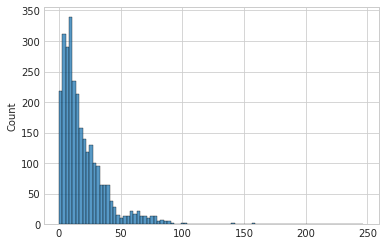

In [9]:
sns.histplot(df_node_features.carregamento.values)

In [10]:
# Função para remover outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df

In [12]:
# mudar a cor do box para pastel
# sns.boxplot(df_node_features.carregamento.values, 
#             color='',
#             showfliers = False)

In [13]:
df_node_features.carregamento.describe()

count    2833.000000
mean       20.003774
std        19.774341
min         0.000000
25%         7.129252
50%        13.945946
75%        26.725610
max       246.583333
Name: carregamento, dtype: float64

### Target

In [14]:
df_node_features['ocupation'] = 'maximo'
df_node_features['ocupation'][df_node_features.query(" carregamento < 7 ").index] = 'baixa'
df_node_features['ocupation'][df_node_features.query(" carregamento >= 7 and carregamento < 13 ").index]  = 'medio'
df_node_features['ocupation'][df_node_features.query(" carregamento >= 13 and carregamento < 26 ").index]  = 'alto'

In [ ]:
df_node_features['ocupation'].value_counts(dropna=False)

### Pre-processing

In [ ]:
df_node_features = df_node_features.drop(['target'], axis=1)
df_node_features = df_node_features.rename({'ponto': 'leg_pos'}, axis=1)
df_node_features = df_node_features.astype({'leg_pos': str})

#df_edges_features = df_edges_features.drop(['vm_edge'], axis=1)
df_edges_features.head()

In [ ]:
# columns to select as features
features_cols = ['vm', 'desce', 'linha', 'sobe', 'trip_id', 'veiculo', 'ocupation']

In [ ]:
df_edges_features = df_edges_features.rename({'src': 'pos1', 'dst': 'pos2', 'distance': 'weight'}, axis=1)
df_edges_features = df_edges_features.astype({'pos1': str, 'pos2': str})
df_edges_features.head()

In [ ]:
df_node_features.head()

In [ ]:
df_node_features.ocupation.value_counts(dropna=False)

In [ ]:
x, y, edge_index, edge_weights, pos =  pre_processing(df_edges_features, 
                                                                df_node_features, 
                                                                features_cols,
                                                                col_target='ocupation')

In [ ]:
y_ohe = torch.nn.functional.one_hot(y).float()
y_ohe.shape

In [ ]:
x.shape, y.shape, edge_index.shape, edge_weights.shape, y_ohe.shape

In [ ]:
sns.boxplot(edge_weights.numpy())

## Create K Fold

In [ ]:
folder = '../../data/graph_designer/train_test_node_classification/'

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(x)):
    fold_idx = fold + 1
    print(f"Fold {fold_idx}")

    # Create Data objects
    data = Data(
        x=x,
        y=y_ohe,
        edge_index=edge_index.t(),
        edge_attr=edge_weights
    )

    
    data['train_mask'] = train_idx
    data['test_mask'] = test_idx
    
    # save
    torch.save(data, f'{folder}data_{fold_idx}.pt')

    # Print out the fold results (or store them for later analysis)
    print(f"Train data: {data}")